In [2]:
import pandas as pd
from load_data import load_data_cleansed
pd.set_option('display.max_columns', None)
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sn

In [8]:
price, listings, reviews = load_data_cleansed()

In [9]:
am_df = pd.read_csv("amenities.csv")

listings = listings.join(am_df)

also drop all text variables for the moment

In [10]:

listings = listings.drop(["name", "host_since","Unnamed: 0", "first_review", "last_review","host_name", "last_scraped", "description", "neighborhood_overview", "host_about", "amenities"], axis = 1)

In [11]:
listings = listings.join(pd.get_dummies(listings["host_location_country"]))
listings = listings.join(pd.get_dummies(listings["bath_kind"]))
#listings = listings.join(pd.get_dummies(listings["host_is_superhost"]))
#listings = listings.join(pd.get_dummies(listings["host_identity_verified"]))
listings = listings.join(pd.get_dummies(listings["neighbourhood_cleansed"]))
listings = listings.join(pd.get_dummies(listings["property_type"]))
#listings = listings.join(pd.get_dummies(listings["room_type"]))
#listings = listings.join(pd.get_dummies(listings["has_availability"]))
#listings = listings.join(pd.get_dummies(listings["instant_bookable"]))

In [16]:
listings = listings.drop(["host_location_country", "bath_kind", "host_is_superhost", "host_identity_verified", "neighbourhood_cleansed", "property_type", "room_type", "has_availability", "instant_bookable"], axis = 1)

In [17]:
listings.head()

,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,bath_number,Essentials,Long term stays allowed,Breakfast,Washer,Kitchen,Hangers,Hot tub,Argentina,Australia,Belgium,Brazil,Bulgaria,Canada,Croatia,France,Germany,India,Ireland,Israel,Italy,Mexico,Netherlands,Others,Poland,Portugal,Spain,Sweden,Switzerland,Turkey,United Kingdom,United States,Normal,Private,Shared,Dn Laoghaire-Rathdown,Dublin City,Fingal,South Dublin,Boat,Camper/RV,Casa particular,Castle,Dome house,Entire bungalow,Entire cabin,Entire chalet,Entire condominium (condo),Entire cottage,Entire guest suite,Entire guesthouse,Entire loft,Entire place,Entire rental unit,Entire residential home,Entire serviced apartment,Entire townhouse,Entire vacation home,Entire villa,Farm stay,Houseboat,Hut,Igloo,Private room,Private room in bed and breakfast,Private room in bungalow,Private room in cabin,Private room in casa particular,Private room in chalet,Private room in condominium (condo),Private room in cottage,Private room in floor,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in loft,Private room in rental unit,Private room in residential home,Private room in serviced apartment,Private room in tiny house,Private room in townhouse,Private room in villa,Room in aparthotel,Room in boutique hotel,Room in hotel,Shared room,Shared room in bed and breakfast,Shared room in bungalow,Shared room in casa particular,Shared room in condominium (condo),Shared room in hostel,Shared room in loft,Shared room in rental unit,Shared room in residential home,Shared room in townhouse,Tiny house,Tipi
0,3.0,53.29178,-6.25792,2,1.0,2.0,3,1125,0,0,22,202,227,0,0,4.77,4.82,4.72,4.92,4.66,4.82,3,1.82,1.5,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,53.29209,-6.25624,2,1.0,1.0,3,21,0,0,21,296,182,0,0,4.79,4.85,4.72,4.88,4.66,4.80,3,2.15,1.5,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,53.39027,-6.23547,1,1.0,1.0,2,21,5,17,35,310,313,2,1,4.75,4.76,4.72,4.90,4.62,4.74,3,3.44,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2.0,53.28326,-6.19188,6,2.0,4.0,1,12,6,8,31,106,288,4,1,4.83,4.87,4.84,4.97,4.77,4.84,2,3.75,1.5,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5.0,53.33744,-6.32363,5,1.0,3.0,4,365,11,18,41,283,50,7,1,4.56,4.86,4.68,4.72,4.30,4.46,5,0.83,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
filter_na = listings.isna().any(axis = 1)
listings = listings[~filter_na]
price = price[~filter_na]

In [19]:
# train full random forest
forest = RandomForestRegressor(10000, random_state = 123, max_features = "sqrt", max_depth = 3)
X_train, X_test, y_train, y_test = train_test_split(listings, price, random_state = 123)

In [20]:
forest.fit(X_train, y_train,)

RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=10000,
                      random_state=123)

In [21]:
forest.score(X_test, y_test)

0.22115376930307595

In [22]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_64089/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


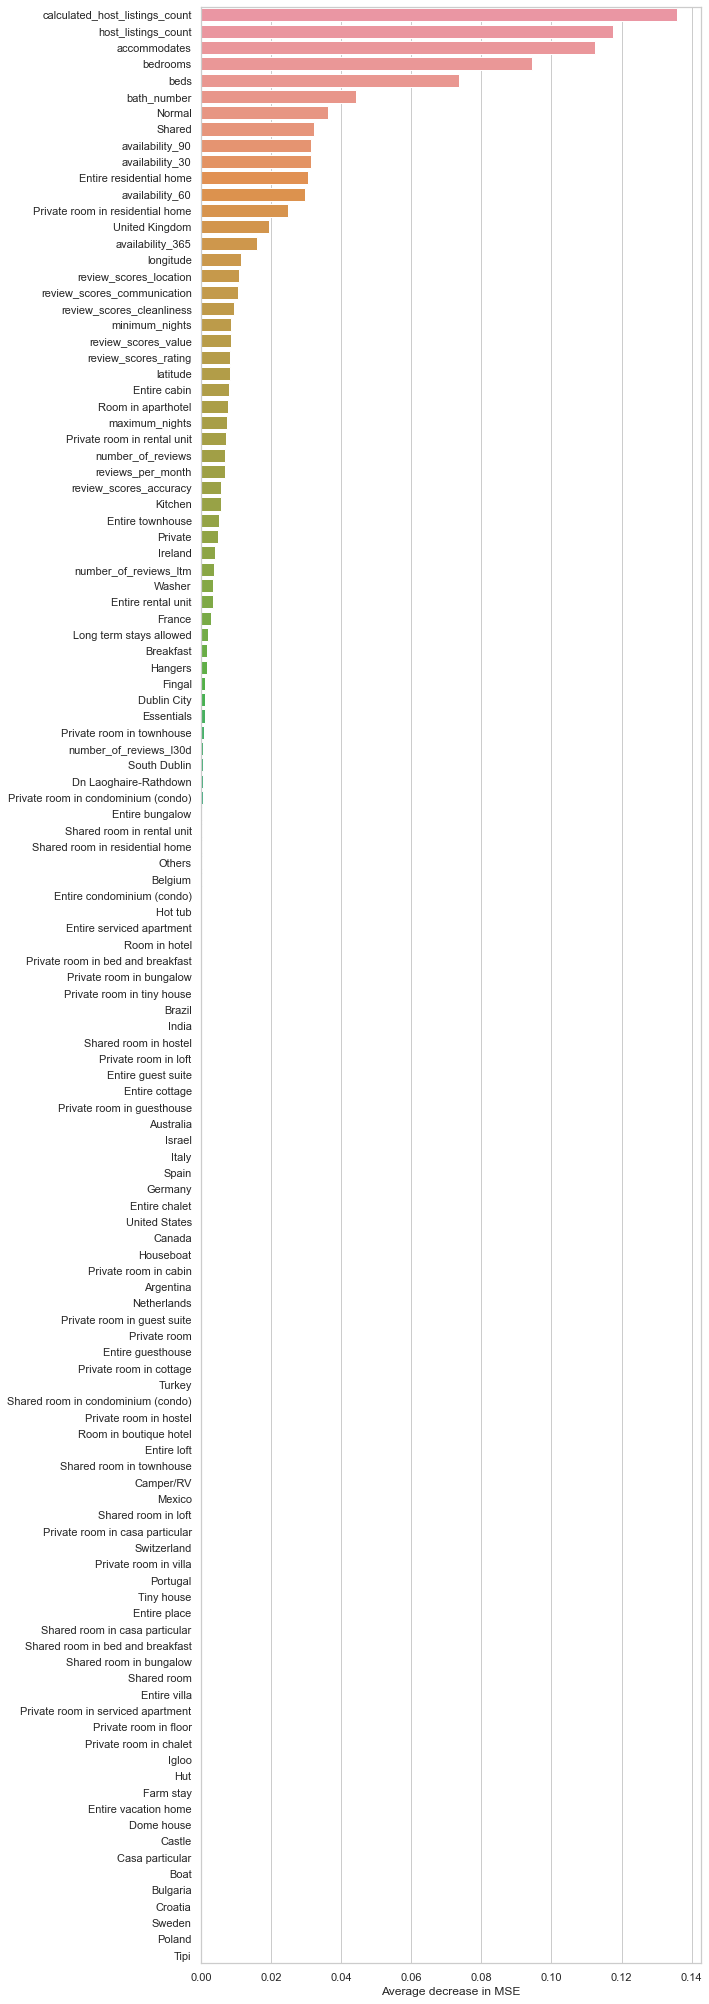

In [23]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

In [ ]:
result = permutation_importance(forest, X_test, y_test, n_repeats=50, random_state=42)

forest_importances = pd.Series(result.importances_mean, index=am_df.columns)

In [ ]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()